In [1]:
%%capture
!pip install datasets

In [2]:
%%capture
# Importing the Required Pacakges and Libraries

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Dataset
from datasets import load_dataset

# tensorflow
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input

# other
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings

# Suppressing Warnings
warnings.filterwarnings("ignore")

In [3]:
# loading the Dataset and viewing it's structure
dataset = load_dataset("cifar10")
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

Text(0.5, 1.0, '0')

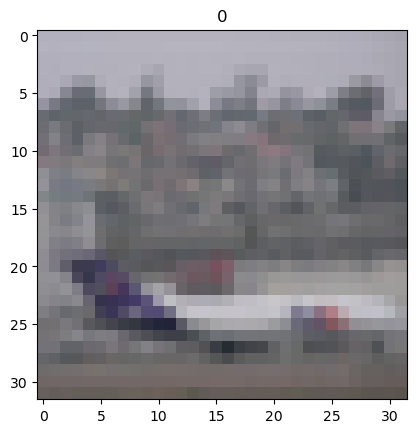

In [4]:
# Viewing Sample Image from Training Data
element = next(iter(dataset["train"]))
plt.imshow(element["img"])
plt.title(element["label"])

## Data Preprocessing

The input image data is converted into numpy arrays which are normalized between 0 and 1 and have a dimesion of 1 row and 32x32x3 columns.

### Training Data

In [5]:
X_train = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["train"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_train = np.array(dataset["train"]["label"][:])

### Test Data

In [6]:
X_test = np.array(
    [(np.array(i)[None, ...] / 255.0).flatten() for i in dataset["test"]["img"][:]]
)  # .reshape(-1, 32 * 32 * 3)
y_test = np.array(dataset["test"]["label"][:])

## Model Performance without ResNet

The data from the previous step is used to train a simple Random Forest model and logistic regression model to get a baseline performance.

The metricts used to evaluate the model are:
- Accuracy
- Time to Train and Predict
- Confusion Matrix

### Decision Trees

In [7]:
# Initializing the Model
model_rf_raw = RandomForestClassifier(n_estimators=100)

# Fitting the Model
t = time.time()
model_rf_raw.fit(X_train, y_train)
print(f"Training Time: {time.time() - t:.2f} Seconds")

Training Time: 160.67 Seconds


In [8]:
# Predicting the Test Data
t = time.time()
y_pred = model_rf_raw.predict(X_test)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.65 Seconds


In [9]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 47.54%
Confusion Matrix: 
[[570  31  43  19  36  20  16  33 169  63]
 [ 27 563  21  34  16  30  36  30  59 184]
 [ 99  48 334  91 137  61 117  59  21  33]
 [ 60  44  75 290  70 178 127  70  23  63]
 [ 53  22 143  49 402  57 140  85  32  17]
 [ 37  29  80 173  76 392  87  68  25  33]
 [  9  39  86  80 100  45 569  21  11  40]
 [ 46  42  49  68  92  77  49 461  23  93]
 [ 90  79  17  23  23  33  11  21 626  77]
 [ 50 182  11  35  15  19  21  44  76 547]]


### Logistic Regression

In [10]:
# Initializing the Model
model_lr_raw = LogisticRegression(
    max_iter=200, multi_class="multinomial", solver="lbfgs", random_state=42
)

# Fitting the Model
t = time.time()
model_lr_raw.fit(X_train, y_train)
print(f"Training Time: {time.time() - t:0.2f} Seconds")

Training Time: 80.25 Seconds


In [11]:
t = time.time()
y_pred = model_lr_raw.predict(X_test)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.09 Seconds


In [12]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 40.74%
Confusion Matrix: 
[[505  44  53  26  30  26  25  47 167  77]
 [ 56 459  34  30  28  35  38  54  89 177]
 [104  42 289  92 121  79 137  72  42  22]
 [ 41  60 105 239  63 208 142  47  36  59]
 [ 59  21 137  71 309  86 160 101  27  29]
 [ 41  50 105 148  92 331  88  64  47  34]
 [ 20  33  69 121  99  90 490  43  14  21]
 [ 47  50  75  67  78  87  46 438  37  75]
 [164  64  24  29  11  44  15  21 538  90]
 [ 67 170  26  25  18  22  53  49  94 476]]


## ResNet Optimized

The raw data is embedded using a pre-trained ResNet model and the output is used to train a Random Forest and Logistic Regression model. The metrics used to evaluate the model are the same as the previous step.

### Embedding the Data using ResNet50

In [14]:
# Load a pretrained model
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,  # take any input shape, not just 224x224
    weights="imagenet",  # use the imagenet pretrained model
    pooling="avg",  # use global average pooling to get a 2048 vector from our image
)

In [15]:
%%capture
def preprocess(img):
    processed_img = preprocess_input(  # ResNet has its own preprocesser
        tf.image.resize(  # Images need to be in (224, 224) dimension
            np.array(img), (224, 224)  # Turn PIL image object into array
        )
    )[None]
    return processed_img


# use resnet to get the embeddings
X_train_resnet = np.array(
    [model.predict(preprocess(i)) for i in dataset["train"]["img"][:]]
).reshape(-1, 2048)
X_test_resnet = np.array(
    [model.predict(preprocess(i)) for i in dataset["test"]["img"][:]]
).reshape(-1, 2048)

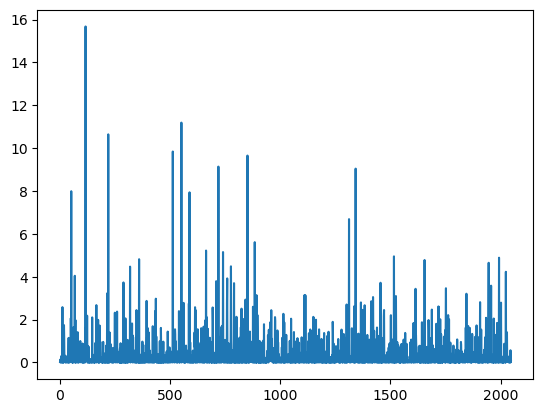

In [16]:
# Viewing 1 sample embedding
plt.plot(X_train_resnet[0].flatten())

### Decision Trees

In [17]:
# Initializing the Model
model_rf_resnet = RandomForestClassifier(n_estimators=100)

# Fitting the Model
t = time.time()
model_rf_resnet.fit(X_train_resnet, y_train)
print(f"Training Time: {time.time() - t:.2f} Seconds")

Training Time: 200.54 Seconds


In [18]:
# predicting the test data
t = time.time()
y_pred = model_rf_resnet.predict(X_test_resnet)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.35 Seconds


In [19]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 86.23%
Confusion Matrix: 
[[886  11  12   8   5   2   4   4  50  18]
 [  5 927   0   4   0   0   2   1   5  56]
 [ 39   2 799  28  58  15  38  12   8   1]
 [  9   4  27 745  33 106  53  12   2   9]
 [  7   2  33  21 841  14  33  45   3   1]
 [  3   2  12 104  26 821   6  24   2   0]
 [  5   0  25  38  13   4 913   0   2   0]
 [ 11   1  17  26  46  32   0 857   6   4]
 [ 40  10   2   6   0   1   3   0 924  14]
 [ 18  53   3   3   0   0   0   1  12 910]]


### Logistic Regression

In [20]:
# Initializing the Model
model_lr_resnet = LogisticRegression(
    max_iter=200, multi_class="multinomial", solver="lbfgs", random_state=42
)

# Fitting the Model
t = time.time()
model_lr_resnet.fit(X_train_resnet, y_train)
print(f"Training Time: {time.time() - t:0.2f} Seconds")

Training Time: 51.29 Seconds


In [21]:
# predicting the test data
t = time.time()
y_pred = model_lr_resnet.predict(X_test_resnet)
print(f"Prediction Time: {time.time() - t:0.2f} Seconds")

Prediction Time: 0.10 Seconds


In [22]:
# Model Evaluation
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_pred)}")

Accuracy: 90.96%
Confusion Matrix: 
[[930   5  12   4   4   0   2   4  29  10]
 [  6 951   0   1   0   1   2   3   6  30]
 [ 14   0 892  21  32   8  20   6   5   2]
 [  2   1  18 826  23  84  24  15   3   4]
 [  2   0  22  25 903   9  14  21   2   2]
 [  2   0  10  90  15 857   5  20   1   0]
 [  4   0  25  29   6   3 930   2   1   0]
 [  4   0   9  17  30  17   1 922   0   0]
 [ 31   3   3   2   1   0   1   0 951   8]
 [  9  37   1   3   1   0   1   2  12 934]]


## Results
The time to embed the data using ResNet50 was higher than the time to embed normally. however, this led to both the models showing an improvement in terms of accuray and and confusion matrix performance.
